## Лабороторна робота 3
## Абрамова Марія

In [207]:
import pandas as pd
import random
import tensorflow as tf 
from matplotlib import pyplot as plt

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Embedding
from tensorflow.keras import Sequential
from sklearn.model_selection import train_test_split

### Get a text dataset

In [208]:
siameseData = pd.read_csv("siamese_nn.csv")
# siameseData["target"] = "siamese neural network"

In [209]:
emotionData = pd.read_csv("emotion_recognition.csv",sep=";")
covidData = pd.read_csv("coranavirus_disease.csv",sep=";")
covidData["target"] = 2
emotionData["target"] = 0

In [210]:
siameseData.head(10)

,text,target
0,Similarity has always been a key aspect in com...,1
1,"Any time two element vectors are compared, man...",1
2,But if the comparison has to be applied to mor...,1
3,"In these cases, a siamese neural network may b...",1
4,The two neural networks are both feedforward p...,1
5,they work parallelly in tandem and compare th...,1
6,The output generated by a siamese neural netwo...,1
7,In this overview we first describe the siamese...,1
8,"Additionally, we list the programming language...",1
9,This section reviews existing tracking method...,1


In [211]:
train_df = pd.concat([emotionData,covidData, siameseData], ignore_index=True )
train_df

,text,target
0,The primary objective of Speech Emotion Recogn...,0
1,"The ideal way to reach this objective, as the ...",0
2,"Nowadays, we are at the dawn of Deep Learning ...",0
3,SER is not an exception since convolutional ne...,0
4,The main advantage of DL is the fact that it r...,0
...,...,...
295,The network applies a ReLU activation function...,1
296,Thus the kth filter map in each layer takes th...,1
297,We have presented a strategy for performing on...,1
298,We outlined new results comparing the performa...,1


### Shuffle training dataframe


In [212]:
train_shuffle=train_df.sample(frac=1,random_state=9) 
train_shuffle.head(10)

,text,target
39,In order to demonstrate the high effectivennes...,0
38,"In this experimental work, we have used Multiv...",0
183,Hao has constructed the ensemble predictor of ...,2
13,. After the last convolutional layer we divide...,0
90,Speech is the main and direct means of transmi...,0
165,Region-wise this distribution depicts total de...,2
44,. It contains 535 utterances spoken by 10 acto...,0
4,The main advantage of DL is the fact that it r...,0
57,The researchers are still debating for what fe...,0
149,"In addition, the introduced method learns to g...",2


In [213]:
train_shuffle.target.value_counts()

0    100
2    100
1    100
Name: target, dtype: int64

In [214]:
train_sentences, test_sentences, train_labels,test_labels = train_test_split(
    train_shuffle['text'].to_numpy(),
    train_shuffle['target'].to_numpy(),
    test_size=0.1, 
    random_state=40
)

len(train_sentences),len(test_sentences),len(train_labels),len(test_labels)

(270, 30, 270, 30)

### Converting text into numbers 

In [215]:
# avg len of sent
max_sq_len = round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))
max_sq_len

24

In [216]:
text_vectorizer = TextVectorization(max_tokens=10000,  #number of word in vocabulary
                                    standardize="lower_and_strip_punctuation", 
                                    split ="whitespace",
                                    output_mode="int",
                                    output_sequence_length=max_sq_len,
                                    pad_to_max_tokens=True)

In [217]:
text_vectorizer.adapt(train_sentences)

In [218]:
### Embedding

embedding = Embedding(
                        input_dim=10000, 
                        output_dim=128, 
                        input_length=max_sq_len, 
                        name = 'embeding_1'
)

In [219]:
random_text = random.choice(train_sentences)
print(random_text)
sample_embed = embedding(text_vectorizer([random_text]))
sample_embed 

These are the best for speech recognition as it takes human perception sensitivity with respect to frequencies into consideration.


<tf.Tensor: shape=(1, 24, 128), dtype=float32, numpy=
array([[[ 3.6321353e-02,  1.8547785e-02, -4.8126329e-02, ...,
         -3.7486564e-02, -1.2688745e-02,  1.8161725e-02],
        [ 4.8959110e-02,  6.0819089e-05,  2.1634173e-02, ...,
          3.2197308e-02,  4.5339141e-02,  3.7505422e-02],
        [ 7.8659430e-03,  4.8172425e-02,  8.6588264e-03, ...,
          1.2711618e-02, -3.4859668e-02,  6.0741678e-03],
        ...,
        [-4.7935437e-02, -1.4710486e-02,  5.3667314e-03, ...,
         -2.9477883e-02, -3.8147222e-02, -1.5861619e-02],
        [-4.7935437e-02, -1.4710486e-02,  5.3667314e-03, ...,
         -2.9477883e-02, -3.8147222e-02, -1.5861619e-02],
        [-4.7935437e-02, -1.4710486e-02,  5.3667314e-03, ...,
         -2.9477883e-02, -3.8147222e-02, -1.5861619e-02]]], dtype=float32)>

## Helper Function to evaluate: accuracy, precision, recall, f1-score

In [220]:

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

## Model 0: Naive Bayes

In [221]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [222]:
model_0= Pipeline([ 
    ("tfidf",TfidfVectorizer()), 
    ("clf", MultinomialNB())
])

In [223]:
model_0.fit(train_sentences,train_labels)


Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [224]:
y_hat0=model_0.predict(test_sentences)
y_hat0

array([0, 0, 1, 1, 0, 0, 1, 0, 2, 0, 2, 2, 0, 0, 2, 1, 0, 2, 1, 2, 1, 2,
       0, 0, 1, 2, 0, 1, 1, 1])

In [225]:
baseline_score= model_0.score(test_sentences,test_labels)

baseline_score

0.9666666666666667

In [226]:
calculate_results(test_labels,y_hat0)

{'accuracy': 96.66666666666667,
 'precision': 0.9694444444444444,
 'recall': 0.9666666666666667,
 'f1': 0.9664109121909632}

In [227]:
y = embedding(text_vectorizer([random_text]))
y

<tf.Tensor: shape=(1, 24, 128), dtype=float32, numpy=
array([[[ 3.6321353e-02,  1.8547785e-02, -4.8126329e-02, ...,
         -3.7486564e-02, -1.2688745e-02,  1.8161725e-02],
        [ 4.8959110e-02,  6.0819089e-05,  2.1634173e-02, ...,
          3.2197308e-02,  4.5339141e-02,  3.7505422e-02],
        [ 7.8659430e-03,  4.8172425e-02,  8.6588264e-03, ...,
          1.2711618e-02, -3.4859668e-02,  6.0741678e-03],
        ...,
        [-4.7935437e-02, -1.4710486e-02,  5.3667314e-03, ...,
         -2.9477883e-02, -3.8147222e-02, -1.5861619e-02],
        [-4.7935437e-02, -1.4710486e-02,  5.3667314e-03, ...,
         -2.9477883e-02, -3.8147222e-02, -1.5861619e-02],
        [-4.7935437e-02, -1.4710486e-02,  5.3667314e-03, ...,
         -2.9477883e-02, -3.8147222e-02, -1.5861619e-02]]], dtype=float32)>

## Model 1: Feed forward NN

In [228]:
from tensorflow.keras import layers



inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x) 
outputs = layers.Dense(3, activation="softmax")(x)

model_1 = tf.keras.Model(inputs,outputs,name="model_1_dense")


In [229]:
model_1.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [230]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_4 (TextVe (None, 24)                0         
_________________________________________________________________
embeding_1 (Embedding)       (None, 24, 128)           1280000   
_________________________________________________________________
global_average_pooling1d_8 ( (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 387       
Total params: 1,280,387
Trainable params: 1,280,387
Non-trainable params: 0
_________________________________________________________________


In [231]:
# Fit the model
model_1_history = model_1.fit(train_sentences,train_labels, epochs=30,validation_data=(test_sentences,test_labels))

Epoch 1/30
9/9 [==============================] - 1s 59ms/step - loss: 1.0949 - accuracy: 0.4148 - val_loss: 1.0882 - val_accuracy: 0.5333
Epoch 2/30
9/9 [==============================] - 0s 42ms/step - loss: 1.0712 - accuracy: 0.7630 - val_loss: 1.0768 - val_accuracy: 0.6667
Epoch 3/30
9/9 [==============================] - 0s 30ms/step - loss: 1.0476 - accuracy: 0.8148 - val_loss: 1.0635 - val_accuracy: 0.6667
Epoch 4/30
9/9 [==============================] - 0s 31ms/step - loss: 1.0205 - accuracy: 0.8333 - val_loss: 1.0479 - val_accuracy: 0.7000
Epoch 5/30
9/9 [==============================] - 0s 26ms/step - loss: 0.9898 - accuracy: 0.8481 - val_loss: 1.0297 - val_accuracy: 0.7000
Epoch 6/30
9/9 [==============================] - 0s 31ms/step - loss: 0.9543 - accuracy: 0.8593 - val_loss: 1.0090 - val_accuracy: 0.7000
Epoch 7/30
9/9 [==============================] - 0s 33ms/step - loss: 0.9143 - accuracy: 0.8815 - val_loss: 0.9851 - val_accuracy: 0.7000
Epoch 8/30
9/9 [===========

In [239]:
# Make predictions (these come back in the form of probabilities)
y_hat1 = model_1.predict(test_sentences)


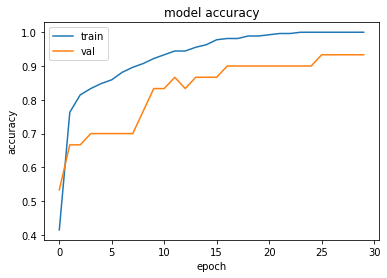

In [233]:
plt.plot(model_1_history.history['accuracy'])
plt.plot(model_1_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

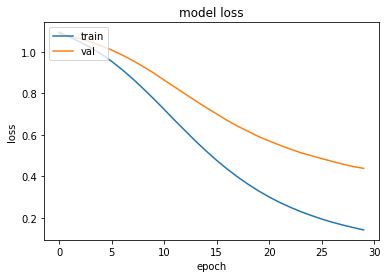

In [240]:
plt.plot(model_1_history.history['loss'])
plt.plot(model_1_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [241]:
model_1.evaluate(test_sentences, test_labels)

1/1 [==============================] - 0s 35ms/step - loss: 0.4392 - accuracy: 0.9333


[0.4392232298851013, 0.9333333373069763]

In [242]:
results = tf.squeeze(tf.argmax(y_hat1, axis = 1))
results

<tf.Tensor: shape=(30,), dtype=int64, numpy=
array([0, 0, 1, 1, 0, 0, 1, 0, 2, 0, 2, 2, 0, 0, 1, 1, 0, 2, 1, 2, 1, 2,
       0, 0, 1, 2, 0, 1, 1, 1])>

In [243]:
calculate_results(test_labels,results)

{'accuracy': 93.33333333333333,
 'precision': 0.939141414141414,
 'recall': 0.9333333333333333,
 'f1': 0.9306849551414769}

In [238]:
calculate_results(test_labels,y_hat0)

{'accuracy': 96.66666666666667,
 'precision': 0.9694444444444444,
 'recall': 0.9666666666666667,
 'f1': 0.9664109121909632}